In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve


import warnings
warnings.filterwarnings("ignore")

plt.rc("font", size=14)

In [2]:
data_raw = pd.read_excel('HZNP_DataScience_Exercise.xlsx',sheet_name = 1)
data_raw.set_index('patientID',inplace = True)
data_raw.head()

,age_at_rf_r1_dx,patient_gender,current_severity,severity_at_HZD_dx,age_current,HZD_dx_age,has_had_surgery,rf_r1_present,rf_r2_present,rf_r3_present,...,previously_tried_px4,previously_tried_px5,previously_tried_px6,previously_tried_px7,previously_tried_px8,previously_tried_px9,previously_tried_px10,previously_tried_px11,previously_tried_px12,recommend_Product_X
patientID,,,,,,,,,,,,,,,,,,,,,
0,NaN,F,Moderate,Moderate,65,55,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,NaN,F,Moderate,Moderate,45,35,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,F,Moderate,Moderate,68,64,0,1,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,NaN,F,Moderate,Mild,41,35,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,71.0,M,Severe,Severe,74,72,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [3]:
#change data type
col_names = list(data_raw)
col_name_num = ["age_at_rf_r1_dx","age_current","HZD_dx_age"] #+data_raw.columns[pd.Series(data_raw.columns).str.startswith('rf_r')].values.tolist()+["px_count_for_HZD_tried","recommend_Product_X"]
col_name_cat = list(set(col_names)-set(col_name_num))

for col in col_name_cat:
    data_raw[col] = data_raw[col].astype('object',copy=False)

In [4]:
feature_data = data_raw.drop('recommend_Product_X', 1)
response_data = data_raw.recommend_Product_X

In [5]:
# imputation categorical
categorical_feature = feature_data.select_dtypes(include=['object'])
categorical_feature = categorical_feature.fillna('missing')
categorical_feature = pd.get_dummies(categorical_feature)

In [6]:
#imputation numerical
numerical_feature = feature_data.select_dtypes(include=[np.number])
#numerical_feature = numerical_feature.fillna(numerical_feature.median())
#numerical_feature.iloc[:,:] = pd.DataFrame(preprocessing.scale(numerical_feature.iloc[:,:])).values

In [7]:
#necessarity of imputation for age_at_rf_r1_dx
numerical_feature.isnull().sum()

age_at_rf_r1_dx    531
age_current          0
HZD_dx_age           0
dtype: int64

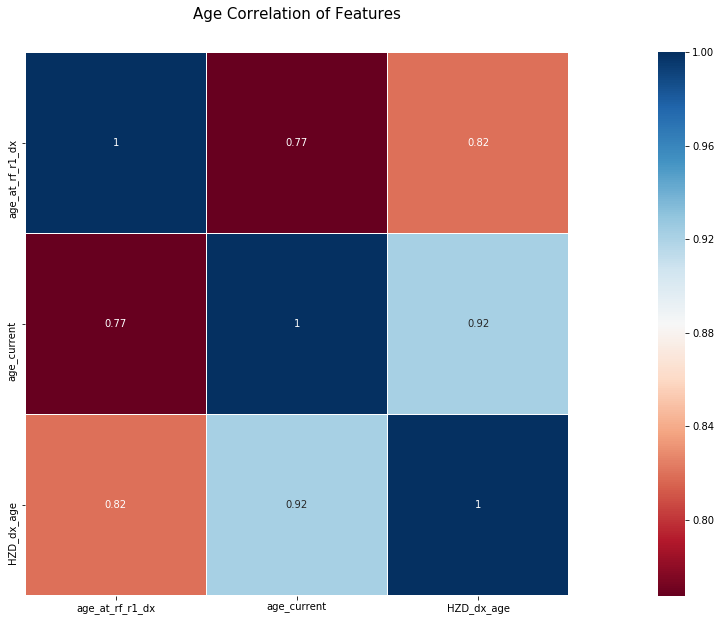

In [8]:
colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Age Correlation of Features', y=1.05, size=15)
sns.heatmap(data_raw.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

In [9]:
#imputation for age_at_rf_r1_dx 
linreg = LinearRegression()
x_train = numerical_feature[numerical_feature['age_at_rf_r1_dx'].notnull()].drop(columns='age_at_rf_r1_dx')
y_train = numerical_feature[numerical_feature['age_at_rf_r1_dx'].notnull()]['age_at_rf_r1_dx']
x_test = numerical_feature[numerical_feature['age_at_rf_r1_dx'].isnull()].drop(columns='age_at_rf_r1_dx')
y_test = numerical_feature[numerical_feature['age_at_rf_r1_dx'].isnull()]['age_at_rf_r1_dx']
linreg.fit(x_train, y_train)
predicted = linreg.predict(x_test)
numerical_feature.age_at_rf_r1_dx[numerical_feature.age_at_rf_r1_dx.isnull()] = predicted

In [10]:
feature_data_final = pd.concat([numerical_feature, categorical_feature], axis=1)

In [11]:
#test and train split
X_train, X_test, y_train, y_test = train_test_split(feature_data_final, response_data, test_size=0.22, random_state=4)
y_train = list(y_train)
y_test = list(y_test)

In [12]:
# randome forest
parameters = {'max_depth':[10,30,50,100],'max_features':[30,50,80,114],'criterion':('gini','entropy')}
rdmfrst_model = RandomForestClassifier(random_state=0,n_estimators=100)
clf0 = GridSearchCV(rdmfrst_model, parameters, cv=5,refit=True)
rdmfrst_model_final = clf0.fit(X_train, y_train).best_estimator_  

In [13]:
clf0.best_params_

{'criterion': 'gini', 'max_depth': 30, 'max_features': 50}

In [14]:
# accurancy on training
clf0.best_score_ 

0.8241678726483358

In [15]:
#accurancy on test
rdmfrst_model_final.score(X_test,y_test)

0.8005115089514067

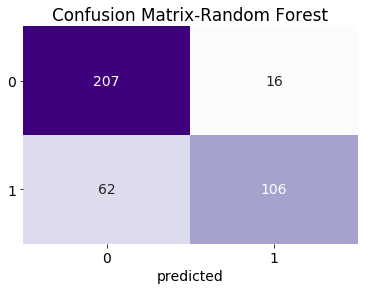

In [56]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_rdmfrst), annot = True, fmt='d', cbar = False, cmap=plt.cm.Purples)
ax.set(xlabel = "predicted", 
       title = "Confusion Matrix-Random Forest")
plt.setp(ax.get_yticklabels(), rotation=0)
plt.show()

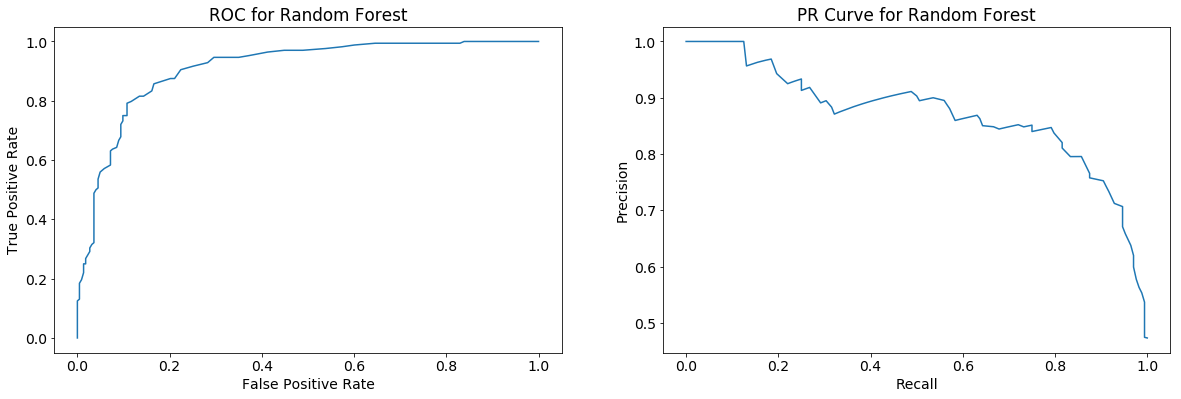

In [70]:
y_pred_prob = clf0.predict_proba(X_test)[:,1]
roc_x, roc_y, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
AUC = auc(roc_x, roc_y)
    
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(roc_x, roc_y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest')
    
plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for recommendation')
plt.title('PR Curve for Random Forest')
    
plt.show()

In [72]:
f1_score(y_test, clf0.predict(X_test))  

0.7310344827586208

Adaboost 

In [47]:
# AdaBoostClassifier
learning_rate_tuning = [5,1,0.5,0.1,0.05]
n_estimators_tuning = [100,500,1000,5000,10000]
model_collection = []
for eta_rate,iteration_n in zip(learning_rate_tuning, n_estimators_tuning):
    parameters = {'learning_rate':[eval('eta_rate')],'n_estimators':[eval('iteration_n')],'base_estimator__max_depth': [10, 30, 50, 100]}
    adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0,max_depth=30,criterion='gini',max_features=50))
    clf1 = GridSearchCV(adaboost_model, parameters, cv=5,refit=True)
    clf1_fit = clf1.fit(X_train, y_train).best_estimator_ 
    model_collection.append(clf1)
    print(clf1.best_score_,clf1.score(X_test,y_test))

0.7510853835021708 0.7493606138107417
0.8386396526772794 0.8695652173913043
0.8379160636758322 0.8542199488491049
0.8241678726483358 0.8388746803069054
0.8205499276410999 0.8132992327365729


In [73]:
f1_score(y_test, model_collection[1].predict(X_test))  

0.8327868852459017

In [74]:
best_ada = model_collection[1].best_params_

{'base_estimator__max_depth': 10, 'learning_rate': 1, 'n_estimators': 500}

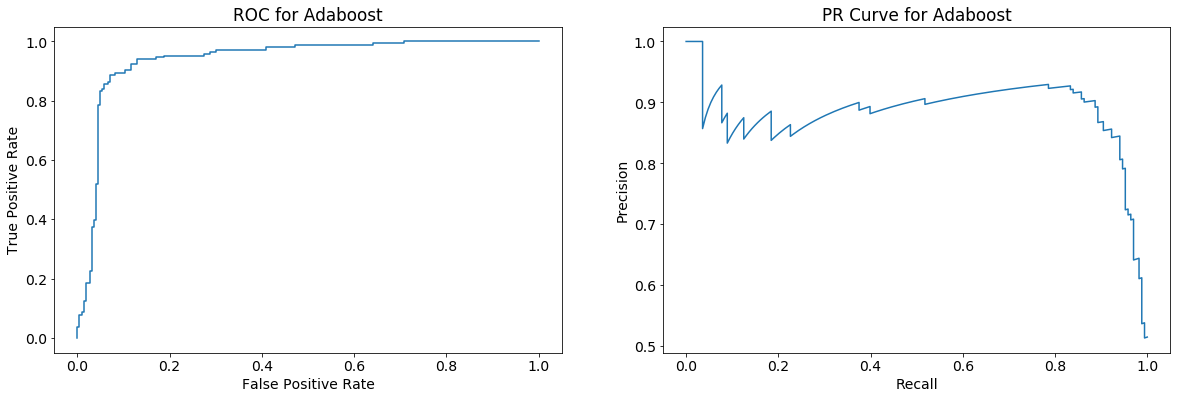

In [75]:
y_pred_prob = model_collection[1].predict_proba(X_test)[:,1]
roc_x, roc_y, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
AUC = auc(roc_x, roc_y)
    
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(roc_x, roc_y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Adaboost')
    
plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for recommendation')
plt.title('PR Curve for Adaboost')
    
plt.show()